<a href="https://colab.research.google.com/github/LuizVicenteJr/insiders_clustering/blob/main/insiders_clustering_cycle1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Planejamento da solução :

* Problema de negócio -> Selecionar os clientes mais valiosos para integrar um programa de fidelização

*Dataset -> Vendas de um e-commerce durante o período de um ano

#Perguntas da equipe de negócios :    
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
* Qual a expectativa de faturamente deste grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
*  Quais as condições para uma pessoa ser removida do Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de marketing pode realizar para aumentar o faturamento




# 0.0 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px

## 0.1 HELPER FUNCTIONS

In [3]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

## 0.2 LOAD DATASET

In [4]:
df_raw = pd.read_csv('/content/Ecommerce.csv',encoding='unicode_escape')

#drop extra column
df_raw= df_raw.drop(columns=['Unnamed: 8'],axis=1)

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [6]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new =['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [8]:
print('Number of rows : {}'.format(df1.shape[0]))
print('Number of rows : {}'.format(df1.shape[1]))

Number of rows : 541909
Number of rows : 8


## 1.3 DATA TYPES

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 CHECK NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 REPLACE NA

In [11]:
df1 = df1.dropna(subset=['description','customer_id'])

print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))


Removed data: 0.25


## 1.6 CHANGE DTYPES

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [14]:
#invoice date
df1['invoice_date']= pd.to_datetime(df1['invoice_date'],format= '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 DESCRIPTIVE STATISTICS

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

In [16]:
df_ref= df2.drop(['invoice_no','stock_code','description','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.1 Feature Creation

In [17]:
#gross revenue 
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#monetary
df_monetary= df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref= pd.merge(df_ref,df_monetary,on='customer_id',how='left')

#recency
df_recency= df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days']= (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency= df_recency[['customer_id','recency_days']].copy()

df_ref= pd.merge(df_ref,df_recency,on='customer_id',how='left')

#frequency
df_freq= df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref= pd.merge(df_ref,df_freq,on='customer_id',how='left')

In [18]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3.0 DATA FILTER

In [19]:
df3 = df_ref.copy()

# 4.0 EDA


In [20]:
df4= df3.copy()

# 5.0 DATA PREPARATION

In [21]:
df5 = df4.copy()

# 6.0 FEATURE SELECTION

In [22]:
df6= df5.copy()

#7.0 Hyperparameter Fine-Tuning

In [23]:
X= df6.drop(columns=['customer_id'])

In [24]:
clusters= [2,3,4,5,6]

## 7.1 Within-Cluster Sum of Square

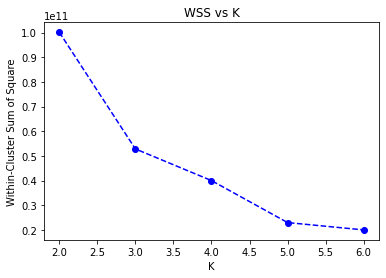

In [25]:
wss=[]
for k in clusters:
  #model definition
  kmeans= c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)

  #model training
  kmeans.fit(X)

  #validation
  wss.append(kmeans.inertia_)

#plot wss - elbow method
plt.plot(clusters,wss,linestyle='--',marker= 'o',color= 'b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square'); 
plt.title('WSS vs K');

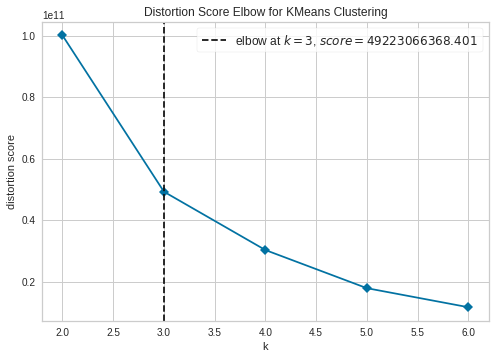

In [26]:
from yellowbrick.cluster import KElbowVisualizer

kmeans= KElbowVisualizer(c.KMeans(), k=clusters,timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Sillhouette Score

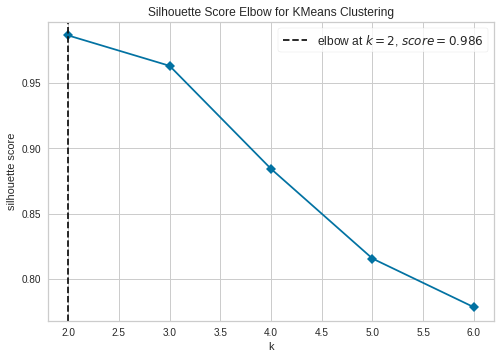

In [27]:
from yellowbrick.cluster import KElbowVisualizer
kmeans= KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

# 8.0 MODEL TRAINING

## 8.1 K-MEANS

In [28]:
#model definition
k=3
kmeans= c.KMeans(init='random', n_clusters= k, n_init= 10, max_iter= 300, random_state= 42)

#model training
kmeans.fit(X)

#clustering
labels= kmeans.labels_

In [29]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))
 
#SS
print('SS value: {}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value: 52830442008.0069
SS value: 0.9494677566681542


# 9.0 Cluster Analysis

In [33]:
df9 = df6.copy()
df9['cluster']= labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## 9.1 Visualization Inspection

In [34]:
fig= px.scatter_3d(df9,x='recency_days',y='invoice_no',z='gross_revenue',color='cluster')
fig.show()

In [44]:
#number of customer
df_cluster= df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer']= 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

#avg gross revenue
df_avg_gross_revenue= df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue,how='inner',on='cluster')

#avg recency days
df_avg_recency_days= df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days,how='inner',on='cluster')

#avg invoice no
df_invoice_no= df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_invoice_no,how='inner',on='cluster')


In [45]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


### Cluster 0 : 
- Número de customers : 4335 ( 99% da base)
- Recência média : 92 dias
- Compras em média : 5 compras
- Receita em média : $ 1.372,57 dólars

### Cluster 1 : 
- Número de customers : 6 ( 0.14% da base)
- Recência média : 7 dias
- Compras em média : 89 compras
- Receita em média : $ 182.182,00 dólars

### Cluster 2 : 
- Número de customers : 31 ( 0.7% da base)
- Recência média : 14 dias
- Compras em média : 53 compras
- Receita em média : $ 40.543,52 dólars